<a href="https://colab.research.google.com/github/reda-maizate/fl_reco/blob/master/flowers_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files
files.upload()

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
'chmod 600 /root/.kaggle/kaggle.json'
!pwd
!kaggle datasets download -d alxmamaev/flowers-recognition
!unzip flowers-recognition.zip

In [0]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data.dataset import Dataset
import torch.optim as optim
from torch import nn
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from fastai.basic_data import DataBunch
from fastai.train import Learner
from fastai.metrics import accuracy
from fastai import *
from fastai.vision import *
import shutil

In [0]:
data_dir = '/content/flowers/flowers'

In [0]:
classes = os.listdir(data_dir)
total = 0

for name in classes:
  print(name, ':', len(os.listdir(data_dir+'/'+name)))
  total += len(os.listdir(data_dir+'/'+name))

print("Number total of images:", total)

dandelion : 1055
daisy : 769
tulip : 984
rose : 784
sunflower : 734
Number total of images: 4326


In [0]:
%pwd

'/content'

In [0]:
# Make a parent directory `data` and two sub directories `train`, `valid` and `test`
%mkdir -p data/train
%mkdir -p data/valid
%mkdir -p data/test

# Inside the train and validation sub-directories, make sub-directories for each catgeory
%cd data
%mkdir -p train/daisy
%mkdir -p train/tulip
%mkdir -p train/sunflower
%mkdir -p train/rose
%mkdir -p train/dandelion

%mkdir -p valid/daisy
%mkdir -p valid/tulip
%mkdir -p valid/sunflower
%mkdir -p valid/rose
%mkdir -p valid/dandelion

%cd ..

/content/data
/content


In [0]:
flowers = []

for species in classes:
    # Get all the file names
    all_flowers = os.listdir(data_dir+'/'+species)
    # Add them to the list
    for flower in all_flowers:
        flowers.append((species, str(data_dir+'/'+species) + '/' + flower))

# Build a dataframe        
flowers = pd.DataFrame(data=flowers, columns=['category', 'image'], index=None)

In [0]:
fl_count = flowers['category'].value_counts()
fl_count

dandelion    1055
tulip         984
rose          784
daisy         769
sunflower     734
Name: category, dtype: int64

In [0]:
len_test = 80

for category in fl_count.index:
    samples = flowers['image'][flowers['category'] == category].values
    perm = np.random.permutation(samples)

    for i in range(len_test):
        name = perm[i].split('/')[-1]
        shutil.copyfile(perm[i],'./data/test/' + str(category) + '_' + name)
    
    for i in range(len_test+1, len_test*2):
        name = perm[i].split('/')[-1]
        shutil.copyfile(perm[i],'./data/valid/' + str(category) + '/'+ name)

    for i in range((len_test*2)+1,len(perm)):
        name = perm[i].split('/')[-1]
        shutil.copyfile(perm[i],'./data/train/' + str(category) + '/' + name)

In [0]:
DATA_PATH = Path('/content/data/')
BATCH_SIZE = 64

In [0]:
data = ImageDataBunch.from_folder(path=DATA_PATH,
                                  train='train',
                                  valid='valid',
                                  ds_tfms=get_transforms(flip_vert=True),
                                  size=224,
                                  bs=BATCH_SIZE
                                  )

In [0]:
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (3518 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
dandelion,dandelion,dandelion,dandelion,dandelion
Path: /content/data;

Valid: LabelList (395 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
dandelion,dandelion,dandelion,dandelion,dandelion
Path: /content/data;

Test: None

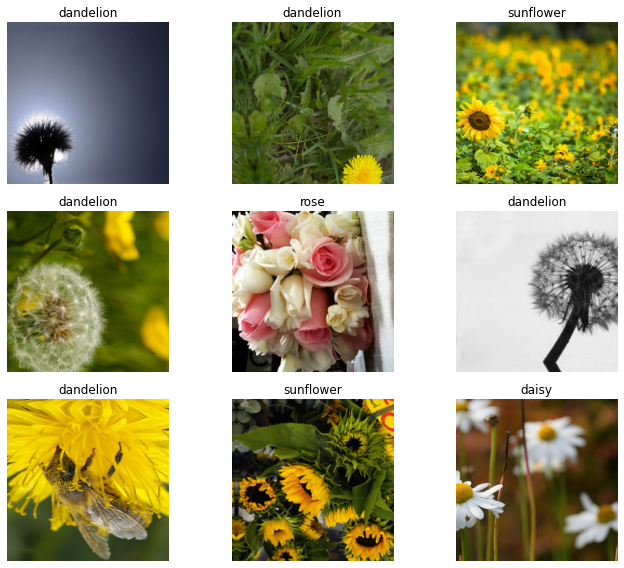

In [0]:
data.show_batch(3, figsize=(10,8))

In [0]:
print(data.classes)
len(data.classes), data.c

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


(5, 5)

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=[error_rate, accuracy])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


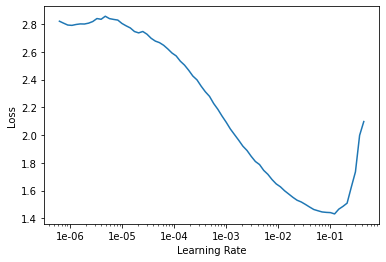

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.819164,0.467691,0.131646,0.868354,01:03
1,0.601299,0.451424,0.141772,0.858228,01:01
2,0.489780,0.395675,0.134177,0.865823,01:01
3,0.400306,0.322682,0.101266,0.898734,01:01
4,0.331505,0.306537,0.096203,0.903797,01:01
5,0.266169,0.305289,0.103797,0.896203,01:01
6,0.222149,0.308875,0.093671,0.906329,01:01
7,0.187264,0.283454,0.081013,0.918987,01:01
8,0.172444,0.261446,0.086076,0.913924,01:01
9,0.160947,0.265911,0.073418,0.926582,01:01


In [0]:
learn.save('flowers_recognition_stage1')

In [0]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.139521,0.265504,0.078481,0.921519,01:20
1,0.138754,0.272646,0.075949,0.924051,01:17
2,0.131820,0.253009,0.073418,0.926582,01:17
3,0.125370,0.241201,0.070886,0.929114,01:17
4,0.120228,0.244035,0.065823,0.934177,01:17


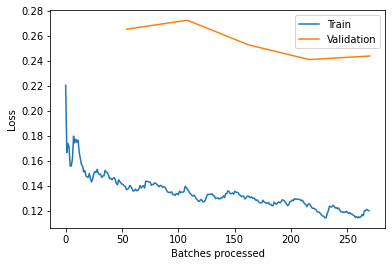

In [0]:
learn.recorder.plot_losses()

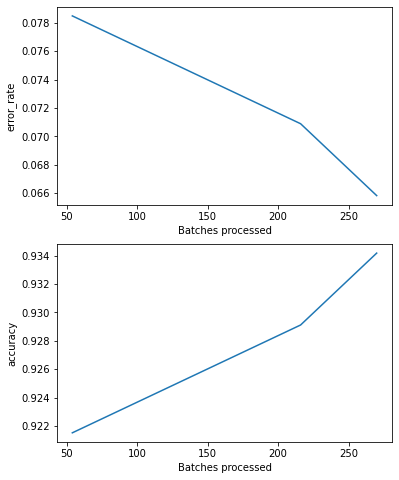

In [0]:
learn.recorder.plot_metrics()

In [0]:
learn.save('flowers_recognition_stage2')

In [0]:
learn.load('flowers_recognition_stage2');

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

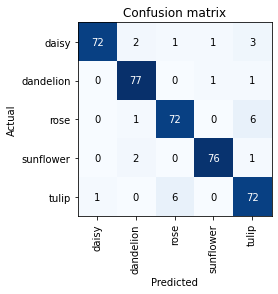

In [0]:
interp.plot_confusion_matrix()

In [0]:
interp.most_confused(min_val=2)

[('rose', 'tulip', 6),
 ('tulip', 'rose', 6),
 ('daisy', 'tulip', 3),
 ('daisy', 'dandelion', 2),
 ('sunflower', 'dandelion', 2)]

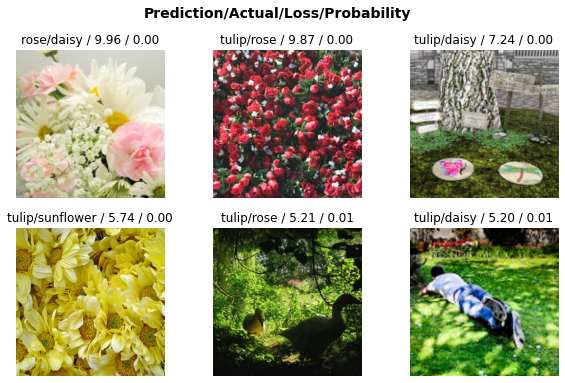

In [0]:
interp.plot_top_losses(6, figsize=(10,6))

In [0]:
learn.export()

In [0]:
TEST_PATH = DATA_PATH/'test'
TEST_FOLDER = ImageList.from_folder(TEST_PATH)

In [0]:
learn = load_learner(DATA_PATH, test=TEST_FOLDER)

In [0]:
preds,y = learn.get_preds(ds_type=DatasetType.Test)

In [0]:
data.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

Path file: /content/data/test/dandelion_2780702427_312333ef33.jpg
Predictions list: [tensor(1.0726e-06), tensor(1.0000), tensor(3.6581e-05), tensor(1.5241e-06), tensor(1.7704e-06)]
Prediction: dandelion
Accuracy: 0.9999589920043945%


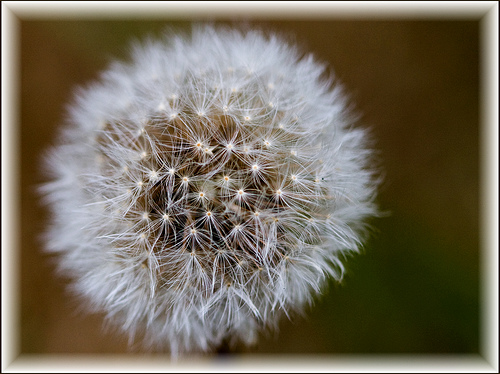

In [133]:
i = 25

print("Path file:", TEST_FOLDER.items[i])
print("Predictions list:", list(preds[i]))
print(f'Prediction: {data.classes[torch.argmax(preds[i])]}')
print(f'Accuracy: {preds[i][torch.argmax(preds[i])]}%')
TEST_FOLDER[i]

Path file: /content/data/test/rose_18563353954_b761d97155_m.jpg
Predictions list: [tensor(4.7570e-06), tensor(0.0001), tensor(0.9703), tensor(0.0002), tensor(0.0294)]
Prediction: rose
Accuracy: 0.9702643752098083%


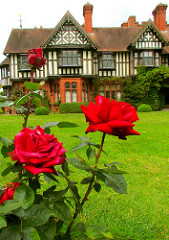

In [135]:
i = 125

print("Path file:", TEST_FOLDER.items[i])
print("Predictions list:", list(preds[i]))
print(f'Prediction: {data.classes[torch.argmax(preds[i])]}')
print(f'Accuracy: {preds[i][torch.argmax(preds[i])]}%')
TEST_FOLDER[i]

Path file: /content/data/test/dandelion_34583574661_8010a1fdf4_n.jpg
Predictions list: [tensor(0.0006), tensor(0.9989), tensor(5.0713e-05), tensor(4.3205e-05), tensor(0.0005)]
Prediction: dandelion
Accuracy: 0.9988577365875244%


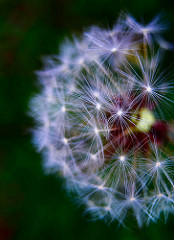

In [136]:
i = 225

print("Path file:", TEST_FOLDER.items[i])
print("Predictions list:", list(preds[i]))
print(f'Prediction: {data.classes[torch.argmax(preds[i])]}')
print(f'Accuracy: {preds[i][torch.argmax(preds[i])]}%')
TEST_FOLDER[i]

Path file: /content/data/test/tulip_5653364300_bc557236c7_n.jpg
Predictions list: [tensor(1.1528e-07), tensor(2.8959e-07), tensor(0.0005), tensor(1.2366e-05), tensor(0.9995)]
Prediction: tulip
Accuracy: 0.9994843006134033%


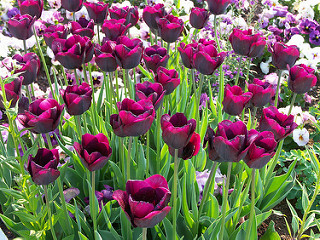

In [137]:
i = 325

print("Path file:", TEST_FOLDER.items[i])
print("Predictions list:", list(preds[i]))
print(f'Prediction: {data.classes[torch.argmax(preds[i])]}')
print(f'Accuracy: {preds[i][torch.argmax(preds[i])]}%')
TEST_FOLDER[i]

Path file: /content/data/test/daisy_14114116486_0bb6649bc1_m.jpg
Predictions list: [tensor(1.0000), tensor(1.1563e-06), tensor(6.1247e-09), tensor(3.2112e-08), tensor(1.0538e-07)]
Prediction: daisy
Accuracy: 0.9999986886978149%


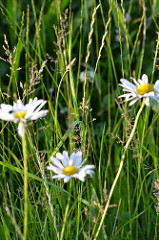

In [138]:
i = 399

print("Path file:", TEST_FOLDER.items[i])
print("Predictions list:", list(preds[i]))
print(f'Prediction: {data.classes[torch.argmax(preds[i])]}')
print(f'Accuracy: {preds[i][torch.argmax(preds[i])]}%')
TEST_FOLDER[i]